#!M
# Как найти стог сена в иголке? Практический проект по построению системы поиска аномалий

**Цель:** В этом домашнем задании вам предстоит настроить систему по поиску аномалий в банковских транзакциях. Мало того, что аномальных значений в данных меньше одного процента, так еще и переменные анонимизированные и представляют собой первые 28 главных компонент, полученных после PCA преобразования оригинальных данных (о которых мы ничего не знаем). Смогут ли бравые unsupervised методы справится с такой задачей? Можно ли работать в таких условиях? Кто подставил кролика Роджера? Ответы на некоторые их этих вопросов вы узнаете после выполнения задания :)

1. Скачайте датасет с [https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv) и
2. Проведите небольшой EDA (гистограммы и описательные статистики - обязательно)
3. Воспользуйтесь процентом аномалий, подсчитанным по переменной Class, как "экспертной оценкой" загрязненности нашего датасета
4. Попробуйте построить различные модели и алгоритмы, разобранные на занятии, используя полученную экспертную оценку для настройки параметров
5. Воспользуйтесь стандартными методами оценки качества бинарной классификации (особенно хорошо подойдёт classification report и confusion matrix), и, используя предсказания моделей и переменную Class, проверьте, действительно ли модели справляются со своей задачей и на сколько хорошо они это делают
6. При помощи tSNE и/или UMAP, постройте сжатое представление исходных данных и проверьте, действительно ли аномалии лежат достаточно далеко от основной массы точек

## Критерии оценки

- Базовый EDA - 2 балла
- Построены различные алгоритмы по поиску аномалий (основанные на расстояниях, плотностях и используя модели) - 5 баллов
- Проверка качества и отображение на сжатое пространство - 3 балла

In [62]:
#!M
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.tools as tls
 
import seaborn as sns
import sklearn
import scipy
import itertools 


%matplotlib inline

In [63]:
#!M
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

outliers_quality = pd.DataFrame({"metric":["Precision", "Recall", "F1-score", "TP", "FN", "FP"]})
outliers_quality.set_index("metric")

""
metric
Precision
Recall
F1-score
TP
FN
FP


In [64]:
#!M
def fill_report(outliers_quality, y_true, y_pred, model_name):
    report = precision_recall_fscore_support(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    outliers_quality[model_name] = [report[0][1], report[1][1], report[2][1],
                                    matrix[1][1], matrix[1][0], matrix[0][1]]    



In [65]:
#!M
def get_outliers(data, function, threshold=3):
    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    
    for column in data.columns:
        anomalies = function(data, column, threshold=threshold)       
        outliers[anomalies[anomalies].index] = True        
    
    return outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))  
 

In [66]:
#!M
def outlier_iqr(data, column, threshold=3):
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    up_bound = data[column].quantile(0.75) + (IQR * threshold)
    low_bound = data[column].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[column]>up_bound, data[column]<low_bound], axis=1).any(1)
    return anomalies


In [67]:
#!M
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `threshold` based on `percentile`.
    
    Predict method uses `threshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> outlier.
    
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [68]:
#!M
data = pd.read_csv('creditcard.csv')
data.head()
data=data[:5000]

## EDA

In [69]:
#!M
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5000 non-null   float64
 1   V1      5000 non-null   float64
 2   V2      5000 non-null   float64
 3   V3      5000 non-null   float64
 4   V4      5000 non-null   float64
 5   V5      5000 non-null   float64
 6   V6      5000 non-null   float64
 7   V7      5000 non-null   float64
 8   V8      5000 non-null   float64
 9   V9      5000 non-null   float64
 10  V10     5000 non-null   float64
 11  V11     5000 non-null   float64
 12  V12     5000 non-null   float64
 13  V13     5000 non-null   float64
 14  V14     5000 non-null   float64
 15  V15     5000 non-null   float64
 16  V16     5000 non-null   float64
 17  V17     5000 non-null   float64
 18  V18     5000 non-null   float64
 19  V19     5000 non-null   float64
 20  V20     5000 non-null   float64
 21  V21     5000 non-null   float64
 22  

In [70]:
#!M
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2115.711400,-0.231403,0.255613,0.819420,0.017935,-0.001525,0.176218,0.042119,-0.033597,0.235148,...,-0.022922,-0.150092,-0.041217,0.038266,0.096778,-0.048575,0.038384,0.004938,63.801066,0.00060
std,1310.428648,1.373311,1.161780,1.005793,1.421640,1.193638,1.365726,1.056656,1.198995,0.981256,...,0.795750,0.631866,0.369340,0.619742,0.402285,0.492913,0.334735,0.244331,197.469524,0.02449
min,0.000000,-12.168192,-15.732974,-12.389545,-4.657545,-32.092129,-7.465603,-11.164794,-23.632502,-3.336805,...,-11.273890,-5.707801,-7.996811,-2.512377,-2.322906,-1.338556,-5.336289,-2.909294,0.000000,0.00000
25%,965.750000,-0.979465,-0.326502,0.277256,-0.915679,-0.603509,-0.695906,-0.472985,-0.191954,-0.360666,...,-0.242936,-0.587584,-0.190612,-0.341877,-0.138185,-0.416753,-0.042299,-0.016441,3.797500,0.00000
50%,2072.500000,-0.406456,0.325332,0.846885,0.064772,-0.083521,-0.167077,0.064890,0.038273,0.232701,...,-0.092730,-0.173583,-0.048373,0.103362,0.116338,-0.089753,0.021399,0.019665,15.155000,0.00000
75%,3243.500000,1.126137,0.902415,1.455559,0.990035,0.433778,0.580896,0.584885,0.336785,0.756522,...,0.074324,0.282913,0.085965,0.445422,0.357152,0.248768,0.174045,0.082230,57.160000,0.00000
max,4563.000000,1.685314,6.224859,4.101716,6.013346,10.658654,21.393069,34.303177,3.877662,9.272376,...,15.631453,4.393846,4.095021,3.200201,1.972515,3.463246,3.852046,4.157934,7712.430000,1.00000


In [71]:
#!M
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Данные без пропусков. Можно работать

In [72]:
#!M
columns=data.drop(['Class'],axis=1).columns.tolist()


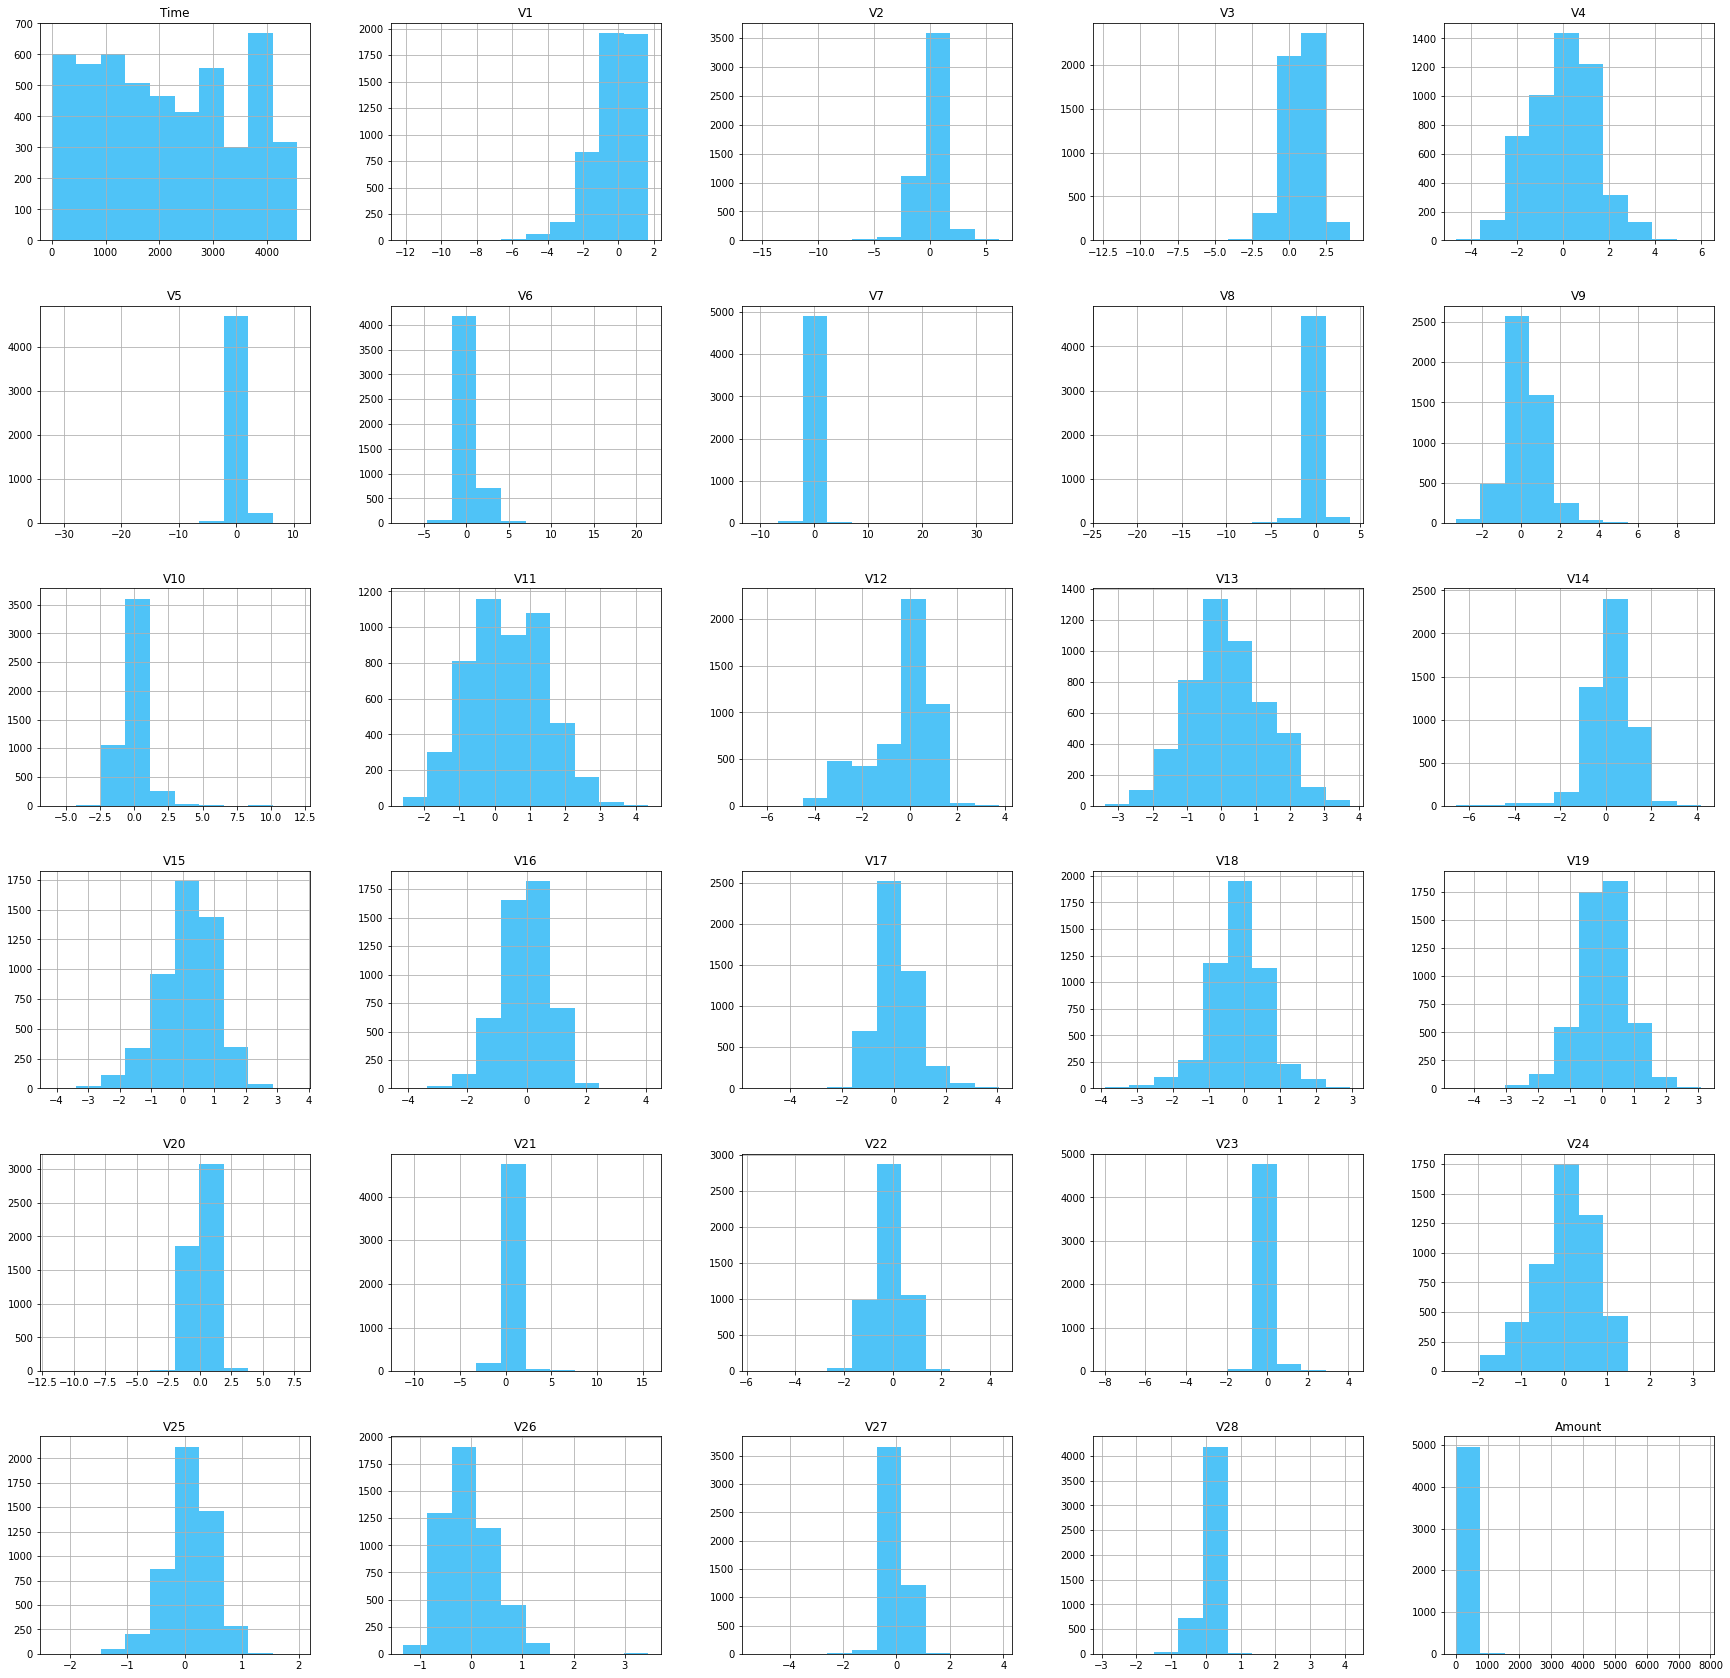

In [73]:
#!M
data[columns].hist(figsize=(30,30),color="#4FC3F7")
plt.show()

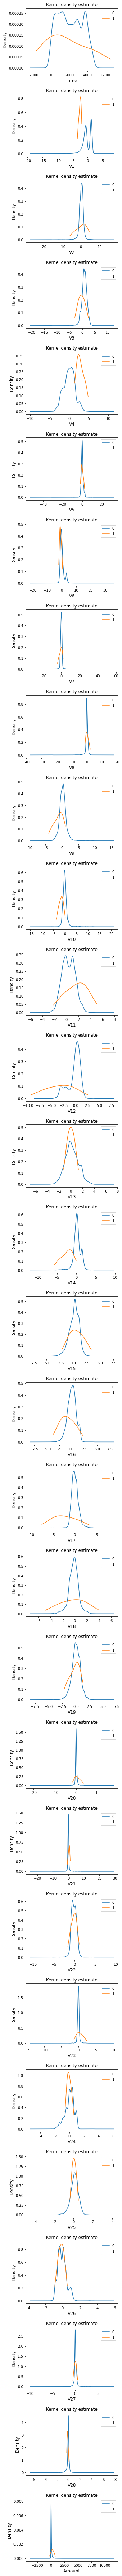

In [74]:
#!M
data_grouped = data.groupby("Class")

# Создадим окружение для графиков, для каждой колонки два стобца
fig, axs = plt.subplots(nrows=len(columns), ncols=1, figsize=(5,100))

for index, column in enumerate(columns):


    # Во втором столбце отобразим график сглаженной плотности распределения на основе ядерной оценки
    data_grouped[column].plot(kind='kde', ax=axs[index])
    axs[index].set_title('Kernel density estimate')
    axs[index].set_xlabel(column, fontsize=12)
    axs[index].set_ylabel('Density', fontsize=12)
    axs[index].legend()

plt.tight_layout(pad=1.5)
plt.show()

### Экспертная оценка 

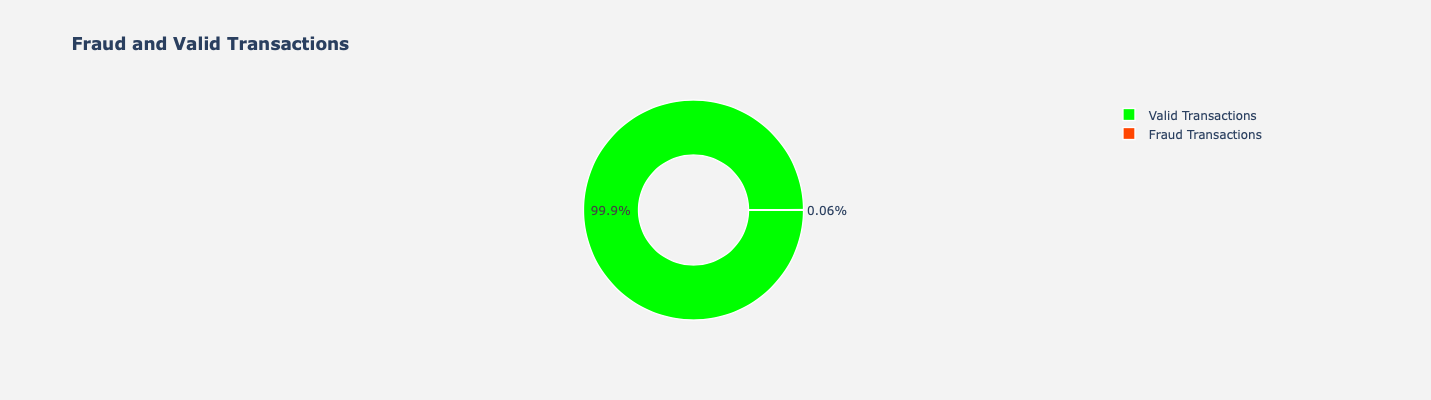

In [77]:
#!M
lab = data["Class"].value_counts().keys().tolist()
#values
val = data["Class"].value_counts().values.tolist()
 
trace = go.Pie(labels = ['Valid Transactions','Fraud Transactions'] ,
               values = val ,
               marker = dict(colors =  ["lime","orangered"],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "<b>Fraud and Valid Transactions<b>",
                        height=400,
                        width=700,
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
 
dataf = [trace]
fig = go.Figure(data = dataf,layout = layout)
py.iplot(fig)

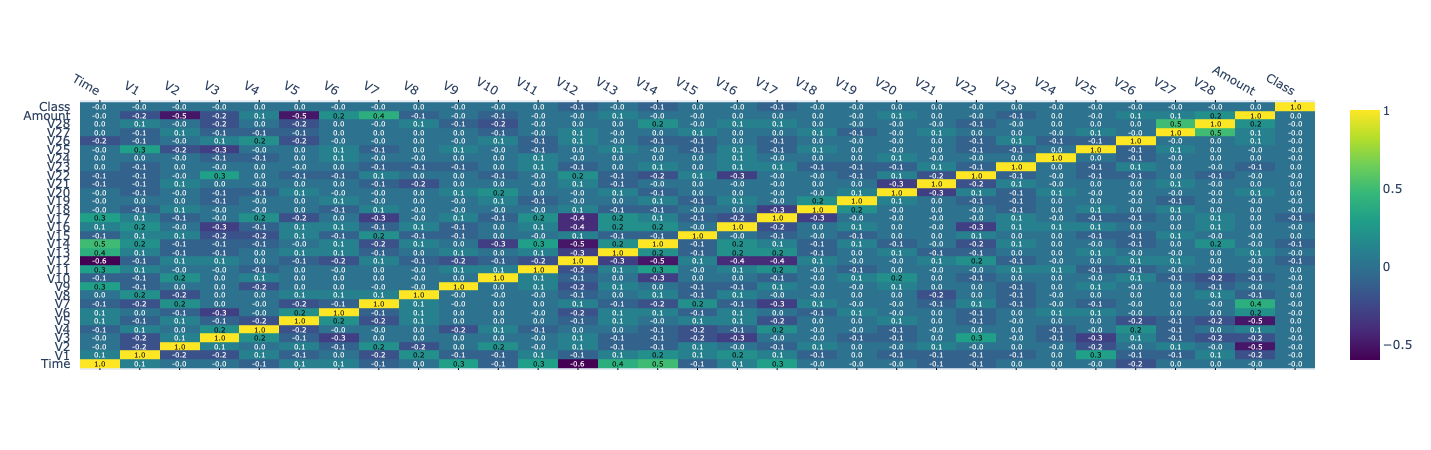

In [78]:
#!M
fig = ff.create_annotated_heatmap(round(data.corr(),1).values.tolist(),
                                  
                                  y=data.columns.tolist(),
                                  x=data.columns.tolist(), 
                                  colorscale="Viridis",
                                  showscale=True
                                 )
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 7

fig.show()

### Поиск аномалий

In [79]:
#!M
from sklearn.preprocessing import RobustScaler

data_features = data.drop('Class', axis=1)
scaler = RobustScaler()
data_scaled = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)
data_features_scaled = data_scaled.copy()
data_scaled['Class'] = data['Class']

In [80]:
#!M
data_scaled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.909889,-0.452769,-0.323954,1.433809,0.689182,-0.245641,0.493002,0.165151,0.114281,0.117336,...,0.234582,0.518578,-0.224535,-0.046277,0.024632,-0.149299,0.518432,-0.412665,2.519841,0
1,-0.909889,0.759077,-0.048157,-0.577445,0.201175,0.138379,0.066350,-0.135832,0.088566,-0.436923,...,-0.419358,-0.534279,0.541116,-0.562948,0.102621,0.324028,-0.140432,-0.050074,-0.233591,0
2,-0.909450,-0.452079,-1.355253,0.786151,0.165296,-0.404591,1.541020,0.686825,0.396042,-1.564065,...,1.073973,1.085888,3.462989,-1.006787,-0.896319,-0.074143,-0.354765,-0.804865,6.811993,0
3,-0.909450,-0.265870,-0.415453,0.802941,-0.486990,0.070580,1.107675,0.163271,0.641456,-1.449823,...,-0.049078,0.205465,-0.513230,-1.624461,1.072074,-0.198605,0.191011,0.423555,2.030358,0
4,-0.909011,-0.357037,0.449505,0.595630,0.177499,-0.312037,0.205982,0.499164,-0.584042,0.523671,...,0.262559,1.116445,-0.322100,0.048145,-0.650765,0.889595,0.915317,1.981211,1.027594,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.092086,0.719623,-0.219944,0.187502,0.890798,-0.381368,0.391849,-0.503449,0.099017,1.720744,...,-0.437743,0.128919,-0.059213,-0.068727,0.953188,-0.312131,0.109482,-0.022569,-0.002905,0
4996,1.092526,0.039665,0.479200,1.463856,1.705313,-0.389032,0.679917,-0.288385,0.554614,0.512530,...,0.499159,0.850171,-0.045009,0.285230,-1.368866,0.595184,0.667093,1.308494,0.000468,0
4997,1.092526,-0.089323,0.226167,0.708285,0.139787,0.412894,0.928029,0.503671,-2.987241,-0.039079,...,0.852026,-0.338299,-0.221592,-0.592107,-1.155627,-0.572099,-2.928843,-5.382678,0.768236,0
4998,1.092965,-0.524511,1.139713,0.121920,-0.277386,-0.488042,-0.452201,-0.130377,1.441995,0.417744,...,-0.377524,-0.221369,0.347811,0.526066,-0.557976,0.481099,0.529201,0.833389,-0.209042,0


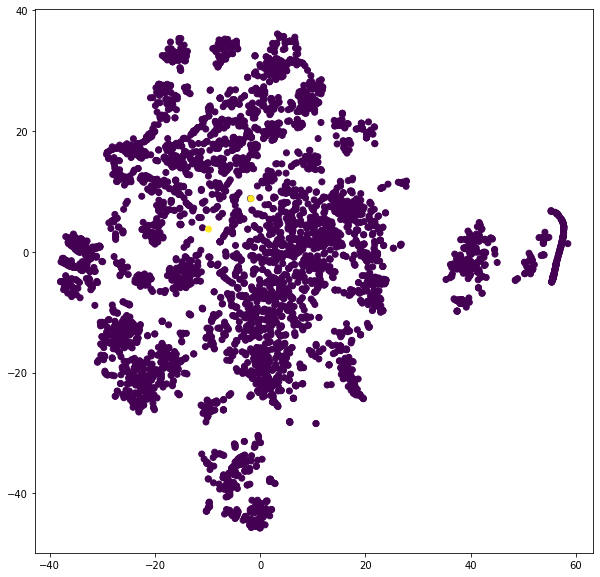

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



In [81]:
#!M
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(data_scaled)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=data['Class'])

In [82]:
#!M
outliers_percentage_actual = data.loc[data['Class'] == 1].shape[0] / data.shape[0] *100
outliers_percentage_actual

0.06

### Простейшие методы

#### 3-сигмы

In [83]:
#!M
def outlier_std(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[column]>up_bound, data[column]<low_bound], axis=1).any(1)
    return anomalies

In [84]:
#!M
std_outliers = get_outliers(data_features, function=outlier_std)
anomalies_report(std_outliers)

Total number of outliers: 623
Percentage of outliers:   12.46


#!M
#### Межквартальное отклонение


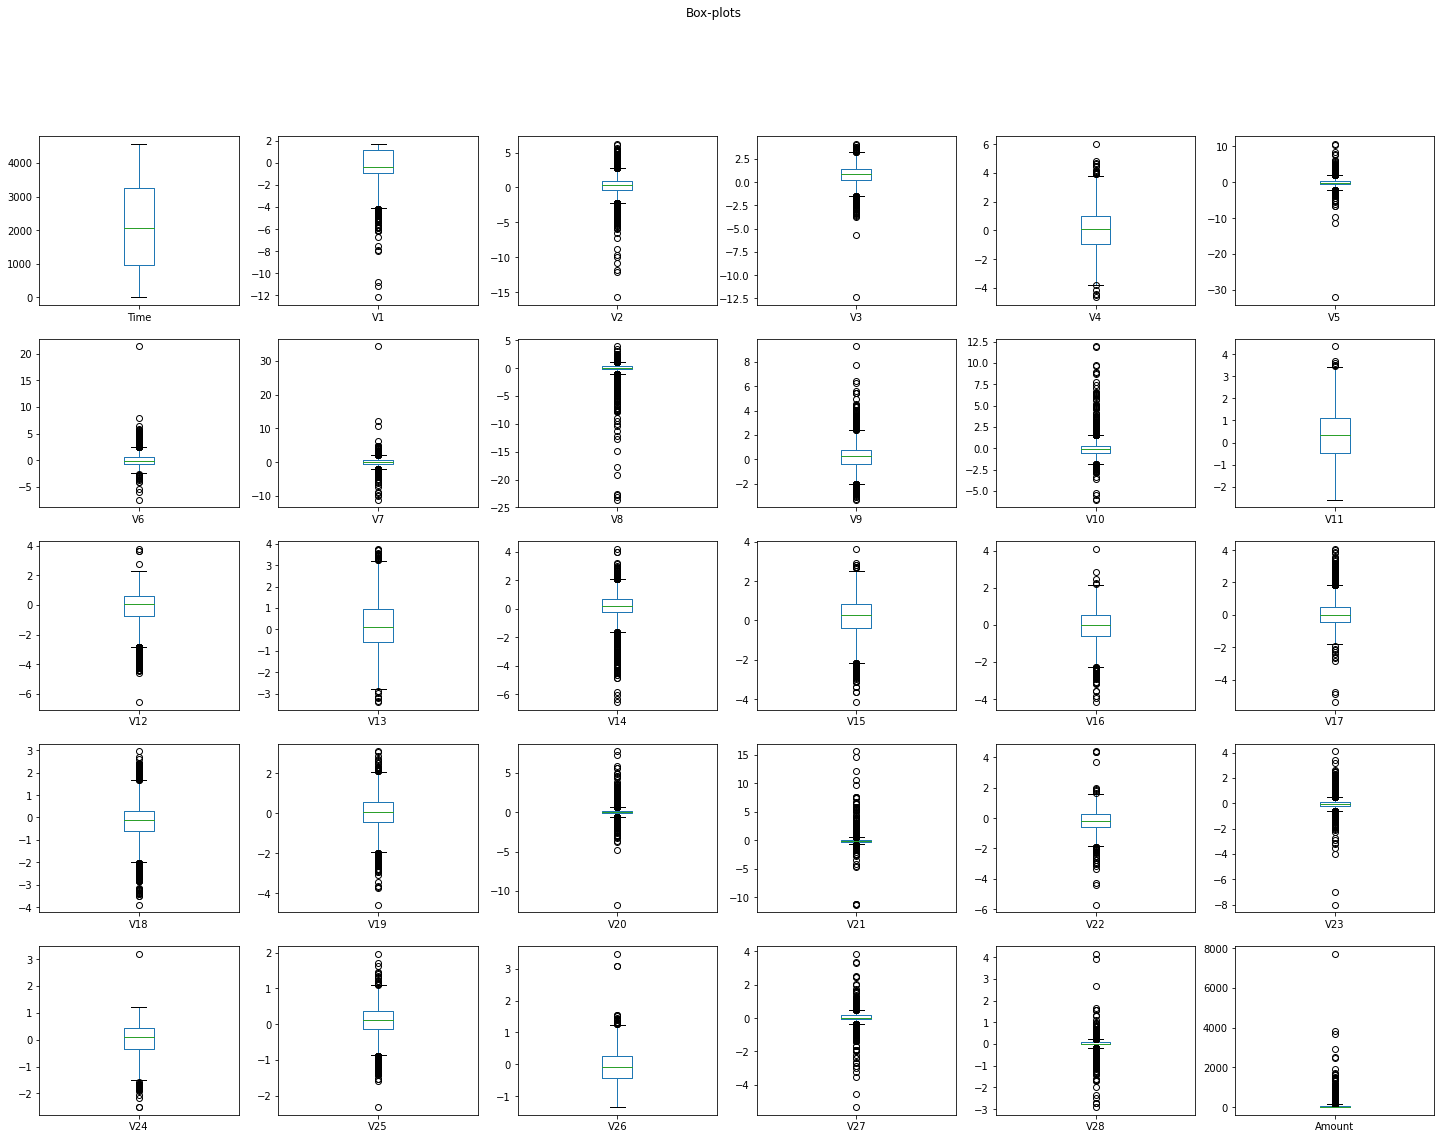

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



In [85]:
#!M
fig, axes = plt.subplots(5, 6, figsize=(25, 18))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(data_features):
    data_features[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 5:
        row+=1
        col=0

#!M
Если обратить внимание на v6 v7 v24 v26 то хорошо видны аномалии

In [86]:
#!M
iqr_outliers = get_outliers(data_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 917
Percentage of outliers:   18.34


#!M
## Distance-based

#!M
#### Euclidean metric

In [87]:
#!M
euclidian_model = DistanceOutliers(metric='euclidean', percentile=100-outliers_percentage_actual)
euclidian_model.fit(data_features_scaled)
euclidian_outliers = euclidian_model.predict(data_features_scaled)
anomalies_report(euclidian_outliers)

Total number of outliers: 3
Percentage of outliers:   0.06


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



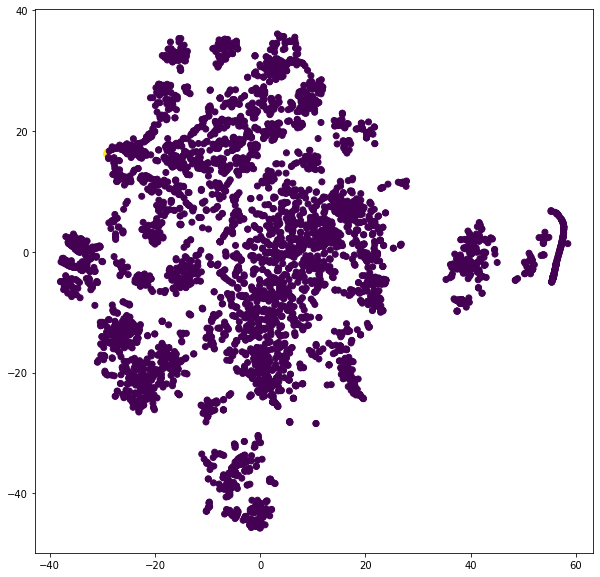

In [89]:
#!M
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

#!M
#### Cityblock metric

In [90]:
#!M
citiblock_model = DistanceOutliers(metric='cityblock', percentile=100-outliers_percentage_actual)
citiblock_model.fit(data_features_scaled)
cityblock_outliers = citiblock_model.predict(data_features_scaled)
anomalies_report(cityblock_outliers)

Total number of outliers: 3
Percentage of outliers:   0.06


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



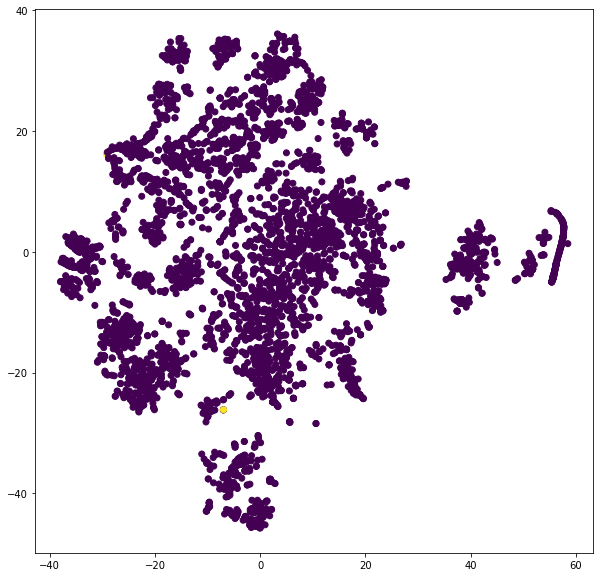

In [92]:
#!M
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers);

#!M
#### DBSCAN

In [94]:
#!M
from sklearn.cluster import DBSCAN

# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 0.05
eps_history = [eps]
while outlier_percentage>0.1:    
    model = DBSCAN(eps=eps).fit(data_features_scaled)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    
model = DBSCAN(eps)
model.fit(data_features_scaled)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



In [95]:
#!M
anomalies_report(density_outlier)

Total number of outliers: 470
Percentage of outliers:   9.40


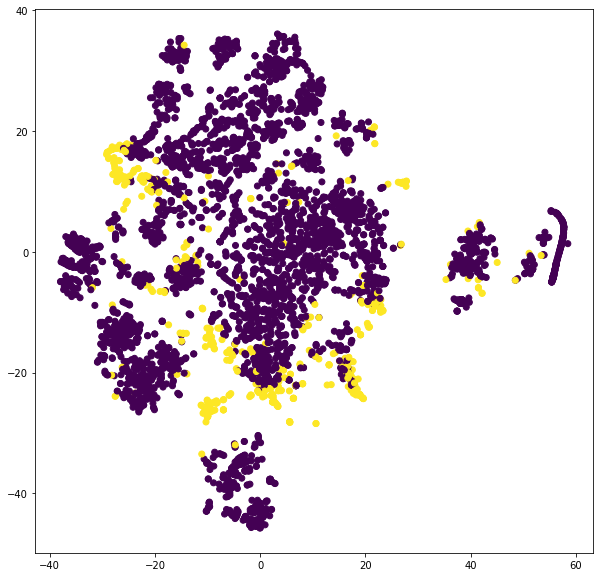

In [96]:
#!M
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=density_outlier);

#!M
### Unsupervised model-based

####  One-Class SVM

In [97]:
#!M
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=outliers_percentage_actual/100, gamma='auto')
one_class_svm.fit(data_features_scaled)
svm_outliers = one_class_svm.predict(data_features_scaled)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



In [98]:
#!M
anomalies_report(svm_outliers)

Total number of outliers: 209
Percentage of outliers:   4.18


#!M
#### Isolation Forest 

In [99]:
#!M
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=outliers_percentage_actual/100, 
                                   max_features=1.0, bootstrap=True, n_jobs=-1)
isolation_forest.fit(data_features_scaled)

isolation_outliers = isolation_forest.predict(data_features_scaled)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:577: UserWarning:

The following variables cannot be serialized: tsne



In [100]:
#!M
anomalies_report(isolation_outliers)

Total number of outliers: 3
Percentage of outliers:   0.06


#!M
## Сравнение качества моделей

In [ ]:
#!M
fill_report(outliers_quality, data['Class'], std_outliers, '3-sigm')
fill_report(outliers_quality, data['Class'], iqr_outliers, 'IQR')
fill_report(outliers_quality, data['Class'], euclidian_outliers, 'Euclidian')
fill_report(outliers_quality, data['Class'], cityblock_outliers, 'Cityblock')
fill_report(outliers_quality, data['Class'], svm_outliers, 'SVM')
fill_report(outliers_quality, data['Class'], isolation_outliers, 'Isolation')

outliers_quality

In [ ]:
#!M
